# 🏠 부동산 실거래가 예측 대회 - KKH - MODEL
> - 학습, 예측, 평가를 진행한다.
> - kimkihong / helpotcreator@gmail.com / Upstage AI Lab 3기
> - 2024.07.16.화 ~ 2024.07.19.금 19:00

In [354]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(fname=r'font/NanumGothic.otf', name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import re
import math
import joblib

# Model
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoost
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder

# Optuna
from optuna import create_study
from optuna.integration import OptunaSearchCV
from optuna.samplers import TPESampler
import optuna

import eli5
from eli5.sklearn import PermutationImportance

# 모든 열을 표시하도록 설정
pd.set_option('display.max_columns', None)

In [355]:
train = pd.read_csv('data/kkh_train.csv', encoding='utf-8')
test = pd.read_csv('data/kkh_test.csv', encoding='utf-8')
loan = pd.read_csv('data/kkh_loan.csv', encoding='utf-8') # 서울시 가계대출규모
kb = pd.read_csv('data/jaemyung_kb.csv', encoding='utf-8')

In [356]:
train = pd.merge(train, kb, left_on='계약년월', right_on='date', how='left')
train = train.drop(columns=['date'])

test = pd.merge(test, kb, left_on='계약년월', right_on='date', how='left')
test = test.drop(columns=['date'])

In [357]:
train.sample(3)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,target,구,동,좌표X,좌표Y,동+아파트명,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,5분이하_역_개수,5분초과_10분이하_역_개수,kb부동산지수
997336,서울특별시 송파구 잠실동,22,22.0,0.0,리센츠,84.9900,201007,22,9,2008,올림픽로 135,NaN,,-,-,NaN,024190035,024190039,4.0,분양,위탁관리,혼합식,지역난방,65.0,5563.0,"우방,삼성,대우,대림","우방,삼성,대우,대림",2008-07-31 00:00:00.0,935053.0,447330.0,581999.0,1113.0,3590.0,860.0,NaN,www.movill.net/05502,NaN,2024-07-11 18:13:07.0,90800835801,위탁,단일계약,위탁,33039.07,7451.0,의무,2018-01-29 10:37:55.0,Y,N,2013-03-07 09:46:36.0,91000,송파구,잠실동,127.086025,37.514366,잠실동 리센츠,잠실새내,2호선,298.137618,1,0,16.3
428400,서울특별시 송파구 가락동,166-10,166.0,10.0,진넥스베르디엠,59.9918,201810,19,12,2017,동남로 234,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59000,송파구,가락동,127.133391,37.497355,가락동 진넥스베르디엠,개롱,5호선,149.618502,1,0,86.0
382948,서울특별시 은평구 녹번동,281,281.0,0.0,북한산푸르지오,84.9900,201912,21,6,2015,통일로 660,NaN,,-,-,NaN,023897394,023897395,NaN,기타,위탁관리,계단식,개별난방,22.0,1230.0,대우건설,서울시은평구녹번1구역3지구 조합,2015-07-22 00:00:00.0,194596.0,97932.0,128596.0,327.0,728.0,175.0,NaN,www.bhsprugio.com,NaN,2024-07-11 07:30:29.0,234-82-61891,위탁,종합계약,위탁,13899.27,1532.0,의무,2018-01-30 14:43:39.0,Y,N,2016-08-01 09:33:09.0,90000,은평구,녹번동,126.936533,37.606799,녹번동 북한산푸르지오,녹번,3호선,656.546910,0,1,122.8


In [358]:
train['세대별주차대수'] = train['주차대수'] / train['k-전체세대수']
test['세대별주차대수'] = test['주차대수'] / test['k-전체세대수']

In [359]:
# '계약년월'과 '년월'이 일치하는 경우 '서울시_가계대출' 정보를 train에 병합
train = train.merge(loan, how='left', left_on='계약년월', right_on='년월')
# '년월' 열은 필요 없으므로 삭제
train.drop(columns=['년월'], inplace=True)

test = test.merge(loan, how='left', left_on='계약년월', right_on='년월')
test.drop(columns=['년월'], inplace=True)

In [360]:
# '동+아파트명' 기준으로 그룹화하여 'target' 피처의 평균 가격 계산
mean_target_per_group = train.groupby('동+아파트명')['target'].mean()

# 평균 가격이 200,000 이상인 그룹을 리스트로 생성
high_price_groups = mean_target_per_group[mean_target_per_group >= 200000].index.tolist()

# train 데이터에 'top_apt' 피처 추가
train['top_apt'] = train['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

# test 데이터에 'top_apt' 피처 추가
test['top_apt'] = test['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

In [361]:
train['국민평수'] = train['전용면적(㎡)'].apply(lambda x: 1 if x <= 90 else 0)
test['국민평수'] = test['전용면적(㎡)'].apply(lambda x: 1 if x <= 90 else 0)

In [362]:
# train = train[train['계약년월'] >= 201301]

In [363]:
train = train[~train['층'].isin([-2, 65, 67, 68, 69])]

In [364]:
def update_apt(df):
    # 아파트명 리스트
    apartment_names = [
        "힐스테이트", "푸르지오", "e편한세상", "롯데캐슬", "래미안", "아이파크", "위브", "한화포레나", 
        "자이", "호반베르디움", "더샵", "서희스타힐스", "한라비발디", "우미린", "하늘채", "더플래티넘", 
        "센트레빌", "코아루", "동문굿모닝힐", "리슈빌", "SK뷰", "스위첸", "데시앙", "벽산블루밍"
    ]

    df['아파트명'].fillna('Missing', inplace=True)

    # 아파트명 변경
    changed_count = 0
    for name in apartment_names:
        mask = df['아파트명'].str.contains(name)
        changed_count += mask.sum()  # 변경된 행의 개수 더하기
        df.loc[mask, '아파트명'] = name
    return changed_count

changed_count = update_apt(train)
print(f"train의 '아파트명' 변경된 데이터 수: {changed_count}")

changed_count = update_apt(test)
print(f"test의 '아파트명' 변경된 데이터 수: {changed_count}")


train의 '아파트명' 변경된 데이터 수: 179263
test의 '아파트명' 변경된 데이터 수: 2562


In [365]:
# selected_feature_list = ['아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '구', '동', '도로명', '세대별주차대수', '좌표X', '좌표Y', 'target', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_호선', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수']
# selected_feature_list = ['아파트명', '전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '구', '동', '도로명', '세대별주차대수', '좌표X', '좌표Y', 'target', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_호선', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수', 'kb부동산지수']
selected_feature_list = ['아파트명', '전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '구', '동', '세대별주차대수', '좌표X', '좌표Y', 'target', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-135㎡초과']
# selected_feature_list = ['아파트명', '전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '구', '동', '좌표X', '좌표Y', 'target', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-연면적', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)']
train = train[selected_feature_list]

In [366]:
# train.to_csv('data/kkh_train_final.csv', index=False)

In [367]:
# train.isnull().any(axis=1).sum()
# train_cleaned = train.dropna()

In [368]:
def impute_missing_values(df):
    # 수치형 피처와 범주형 피처 구분
    numeric_features = df.select_dtypes(include=[np.number]).columns
    categorical_features = df.select_dtypes(include=[object]).columns
    
    # 수치형 피처의 결측치를 평균값으로 대체
    # for feature in numeric_features:
    #     mean_value = df[feature].mean()
    #     df[feature].fillna(mean_value, inplace=True)
    
    # 수치형 피처의 결측치를 -999으로 대체
    for feature in numeric_features:
        df[feature].fillna(-999, inplace=True)
    
    # 범주형 피처의 결측치를 'Missing'으로 대체
    for feature in categorical_features:
        df[feature].fillna('Missing', inplace=True)
    
    return df

impute_missing_values(train)

,아파트명,전용면적(㎡),서울시_가계대출,층,건축년도,구,동,세대별주차대수,좌표X,좌표Y,target,top_apt,국민평수,1번째_가까운_역_이름,1번째_가까운_역_거리,kb부동산지수,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-135㎡초과
0,개포6차우성,79.97,282438.7,3,1987,강남구,개포동,0.970370,127.056859,37.476276,124000,0,1,구룡,1187.672025,88.4,20.0,250.0,-999.0
1,개포6차우성,79.97,282438.7,4,1987,강남구,개포동,0.970370,127.056859,37.476276,123500,0,1,구룡,1187.672025,88.4,20.0,250.0,-999.0
2,개포6차우성,54.98,282438.7,5,1987,강남구,개포동,0.970370,127.056859,37.476276,91500,0,1,구룡,1187.672025,88.4,20.0,250.0,-999.0
3,개포6차우성,79.97,283669.8,4,1987,강남구,개포동,0.970370,127.056859,37.476276,130000,0,1,구룡,1187.672025,118.0,20.0,250.0,-999.0
4,개포6차우성,79.97,283669.8,2,1987,강남구,개포동,0.970370,127.056859,37.476276,117000,0,1,구룡,1187.672025,118.0,20.0,250.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,갈현현대,59.94,-999.0,11,1998,은평구,구산동,1.000000,126.905543,37.612989,20000,0,1,구산,1048.367837,-999.0,171.0,141.0,-999.0
1118818,갈현현대,59.94,-999.0,10,1998,은평구,구산동,1.000000,126.905543,37.612989,20000,0,1,구산,1048.367837,-999.0,171.0,141.0,-999.0
1118819,갈현현대,84.83,-999.0,20,1998,은평구,구산동,1.000000,126.905543,37.612989,28000,0,1,구산,1048.367837,-999.0,171.0,141.0,-999.0
1118820,갈현현대,84.83,-999.0,8,1998,은평구,구산동,1.000000,126.905543,37.612989,29000,0,1,구산,1048.367837,-999.0,171.0,141.0,-999.0


In [369]:
print((train.isnull().mean() * 100).to_string())

아파트명                      0.0
전용면적(㎡)                   0.0
서울시_가계대출                  0.0
층                         0.0
건축년도                      0.0
구                         0.0
동                         0.0
세대별주차대수                   0.0
좌표X                       0.0
좌표Y                       0.0
target                    0.0
top_apt                   0.0
국민평수                      0.0
1번째_가까운_역_이름              0.0
1번째_가까운_역_거리              0.0
kb부동산지수                   0.0
k-전용면적별세대현황(60㎡이하)        0.0
k-전용면적별세대현황(60㎡~85㎡이하)    0.0
k-135㎡초과                  0.0


In [370]:
SEED = 53682552

# TARGET 정의
TARGET = 'target'

# NUMERIC_COLS 계산: TARGET을 제외한 수치형 컬럼 리스트
NUMERIC_COLS = [col for col in train.select_dtypes(include=[float, int]).columns if col != TARGET]

# CAT_COLS 계산: NUMERIC_COLS를 제외한 나머지 컬럼 리스트
CAT_COLS = [col for col in train.columns if col not in NUMERIC_COLS + [TARGET]]

# 범주형 변수를 문자열로 변환
for col in CAT_COLS:
    train[col] = train[col].astype(str)

print(f'Target         --> {TARGET}')
print(f'Numeric Cols   --> {NUMERIC_COLS}')
print(f'Categoric Cols --> {CAT_COLS}')

Target         --> target
Numeric Cols   --> ['전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '세대별주차대수', '좌표X', '좌표Y', '국민평수', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-135㎡초과']
Categoric Cols --> ['아파트명', '구', '동', 'top_apt', '1번째_가까운_역_이름']


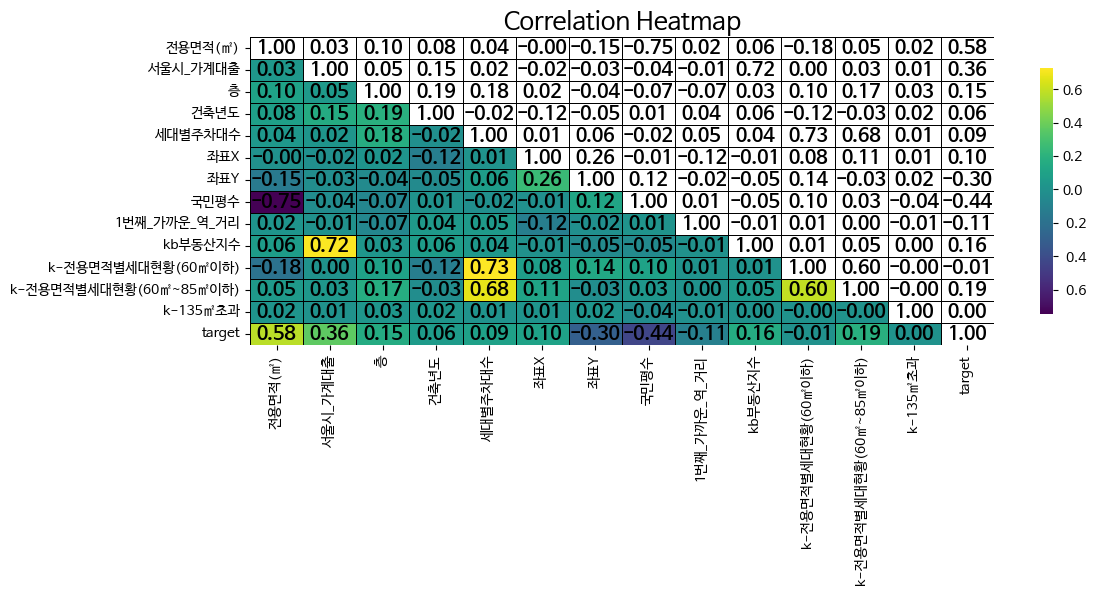

In [371]:
# 상관 행렬 계산
corr = train[NUMERIC_COLS + [TARGET]].corr()

# 마스크 생성
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기
plt.figure(figsize=(12, 4))  # 그래프 크기 조정
ax = sns.heatmap(corr, mask=mask, cmap='viridis', linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8})

# 각 셀에 숫자 추가
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        text = f"{corr.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black',  # 글자색 검은색
                fontsize=14,    # 글자 크기 조정
                fontweight='bold')  # 글자 굵게

# 타이틀 추가
plt.title('Correlation Heatmap', size=18)

# 그래프 표시
plt.show()

In [372]:
# # 데이터 준비
# X = train.drop(columns=['target'])
# y = train['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# # 범주형 열에 대한 레이블 인코딩
# def label_encode_columns(X, cols):
#     for col in cols:
#         le = LabelEncoder()
#         X[col] = le.fit_transform(X[col])
#     return X

# # 전처리 및 모델 파이프라인 설정
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', MinMaxScaler(), NUMERIC_COLS),
#         ('cat', FunctionTransformer(label_encode_columns, kw_args={'cols': CAT_COLS}), CAT_COLS)
#     ], remainder='passthrough')

# # 모델 정의, 학습, 예측, 평가
# results = {}
# kf = KFold(n_splits=3, shuffle=True, random_state=SEED)

# model = CatBoostRegressor(random_state=SEED, verbose=0)
# pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
# cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
# rmse = np.sqrt(-np.mean(cv_scores))
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# results['CatBoost'] = {'R2 Score': r2, 'RMSE': rmse}

# # 결과 출력
# for model_name, metrics in results.items():
#     print(f"@@ model: {model_name}  /  R2: {metrics['R2 Score']:.4f}  / RMSE: {metrics['RMSE']:.4f}")

# # 최고의 모델을 파일로 저장
# best_model_name = 'CatBoost'
# best_rmse = results[best_model_name]['RMSE']
# file_name = f"best_model_{best_model_name}_rmse_{best_rmse:.4f}.pkl"
# joblib.dump(pipeline, file_name)
# print(f"@@ Best model saved as: {file_name}")


In [373]:
X = train.drop(columns=[TARGET])
y = train[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# 범주형 열에 대한 레이블 인코딩
def label_encode_columns(X, cols):
    for col in cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    return X

# 전처리 및 모델 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), NUMERIC_COLS),
        ('cat', FunctionTransformer(label_encode_columns, kw_args={'cols': CAT_COLS}), CAT_COLS)
    ], remainder='passthrough')

# CatBoost 모델 정의 및 학습
catboost_model = CatBoostRegressor(random_state=SEED, verbose=0)
pipeline_catboost = Pipeline(steps=[('preprocessor', preprocessor), ('model', catboost_model)])
kf = KFold(n_splits=2, shuffle=True, random_state=SEED)
cv_scores_catboost = cross_val_score(pipeline_catboost, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmse_catboost = np.sqrt(-np.mean(cv_scores_catboost))
pipeline_catboost.fit(X_train, y_train)
y_pred_catboost = pipeline_catboost.predict(X_test)
r2_catboost = r2_score(y_test, y_pred_catboost)

# Optuna를 사용한 XGBoost 하이퍼파라미터 최적화
def objective_xgb(trial):
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 300, 3000),
        max_depth=trial.suggest_int('max_depth', 5, 30),
        learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        random_state=SEED,
        n_jobs=-1
    )
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    kf = KFold(n_splits=2, shuffle=True, random_state=SEED)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    return -np.mean(cv_scores)

# 옵티마이저 설정 및 최적화
def optimize_model(objective_function, n_trials):
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=SEED))
    study.optimize(objective_function, n_trials=n_trials)
    return study.best_params

n_trials = 1
xgb_best_params = optimize_model(objective_xgb, n_trials)
print(f"@@ XGBoost best params: {xgb_best_params}")

# XGBoost 모델 정의 및 학습
xgb_model = XGBRegressor(**xgb_best_params, random_state=SEED)
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb_model)])
cv_scores_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmse_xgb = np.sqrt(-np.mean(cv_scores_xgb))
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)

# 앙상블 예측
y_pred_ensemble = 0.5 * y_pred_catboost + 0.5 * y_pred_xgb
r2_ensemble = r2_score(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))

# 결과 저장 및 출력
results = {
    'CatBoost': {'R2 Score': r2_catboost, 'RMSE': rmse_catboost},
    'XGBoost': {'R2 Score': r2_xgb, 'RMSE': rmse_xgb},
    'Ensemble': {'R2 Score': r2_ensemble, 'RMSE': rmse_ensemble}
}

for model_name, metrics in results.items():
    print(f"@@ model: {model_name}  /  R2: {metrics['R2 Score']:.4f}  / RMSE: {metrics['RMSE']:.4f}")

# 모델 파일 저장
model_pipes = {
    'CatBoost': pipeline_catboost,
    'XGBoost': pipeline_xgb,
    'Ensemble': (pipeline_catboost, pipeline_xgb)
}

for model_name, pipeline in model_pipes.items():
    if model_name == 'Ensemble':
        file_name = f"{model_name.lower()}_model_rmse_{rmse_ensemble:.4f}.pkl"
        joblib.dump(pipeline, file_name)
        print(f"@@ {model_name} model saved as: {file_name}")
    else:
        rmse = results[model_name]['RMSE']
        file_name = f"{model_name.lower()}_model_rmse_{rmse:.4f}.pkl"
        joblib.dump(pipeline, file_name)
        print(f"@@ {model_name} model saved as: {file_name}")

# 최종 예측값 저장
final_predictions = np.round(y_pred_ensemble).astype(int)
negative_values_indices = np.where(final_predictions < 0)[0]
if len(negative_values_indices) > 0:
    final_predictions_mean = int(np.mean(final_predictions))
    for idx in negative_values_indices:
        print(f"Before: Index {idx}, Value {final_predictions[idx]}")
        final_predictions[idx] = final_predictions_mean
        print(f"After: Index {idx}, Value {final_predictions[idx]}")

[I 2024-07-19 08:45:14,416] A new study created in memory with name: no-name-37fce754-42ae-4682-9922-f78d7107b916
[I 2024-07-19 08:49:17,382] Trial 0 finished with value: 45935115.883243114 and parameters: {'n_estimators': 1546, 'max_depth': 17, 'learning_rate': 0.1009647056027491, 'subsample': 0.8900609831453739, 'colsample_bytree': 0.7326064272241795}. Best is trial 0 with value: 45935115.883243114.


@@ XGBoost best params: {'n_estimators': 1546, 'max_depth': 17, 'learning_rate': 0.1009647056027491, 'subsample': 0.8900609831453739, 'colsample_bytree': 0.7326064272241795}
@@ model: CatBoost  /  R2: 0.9699  / RMSE: 7962.6399
@@ model: XGBoost  /  R2: 0.9809  / RMSE: 6777.5450
@@ model: Ensemble  /  R2: 0.9798  / RMSE: 6598.6890
@@ CatBoost model saved as: catboost_model_rmse_7962.6399.pkl
@@ XGBoost model saved as: xgboost_model_rmse_6777.5450.pkl
@@ Ensemble model saved as: ensemble_model_rmse_6598.6890.pkl


In [374]:
# selected_feature_list = ['아파트명', '전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '구', '동', '도로명', '세대별주차대수', '좌표X', '좌표Y', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과']
# selected_feature_list = ['아파트명', '전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '구', '동', '도로명', '세대별주차대수', '좌표X', '좌표Y', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)']
# selected_feature_list = ['아파트명', '전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '구', '동', '좌표X', '좌표Y', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-연면적', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)']
selected_feature_list = ['아파트명', '전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '구', '동', '세대별주차대수', '좌표X', '좌표Y', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-135㎡초과']

test = test[selected_feature_list]

impute_missing_values(test)

,아파트명,전용면적(㎡),서울시_가계대출,층,건축년도,구,동,세대별주차대수,좌표X,좌표Y,top_apt,국민평수,1번째_가까운_역_이름,1번째_가까운_역_거리,kb부동산지수,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-135㎡초과
0,개포6차우성,79.9700,404538.4,5,1987,강남구,개포동,0.970370,127.056859,37.476276,0,1,구룡,1187.672025,38.0,20.0,250.0,-999.0
1,더샵,108.2017,406315.8,10,2021,강남구,개포동,1.314655,127.057257,37.484829,1,0,구룡,264.330499,46.0,0.0,0.0,-999.0
2,개포우성3차,161.0000,404538.4,15,1984,강남구,개포동,1.034568,127.056019,37.483975,0,0,구룡,405.035364,38.0,0.0,0.0,-999.0
3,개포우성3차,133.4600,406315.8,14,1984,강남구,개포동,1.034568,127.056019,37.483975,0,0,구룡,405.035364,46.0,0.0,0.0,-999.0
4,개포우성3차,104.4300,406315.8,6,1984,강남구,개포동,1.034568,127.056019,37.483975,0,0,구룡,405.035364,46.0,0.0,0.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내우디안1단지,84.6500,404538.4,13,2014,중랑구,신내동,1.118402,127.106467,37.617195,0,1,신내,558.051187,38.0,808.0,504.0,-999.0
9268,신내우디안1단지,84.6200,404538.4,12,2014,중랑구,신내동,1.118402,127.106467,37.617195,0,1,신내,558.051187,38.0,808.0,504.0,-999.0
9269,신내우디안1단지,101.6500,406315.8,12,2014,중랑구,신내동,1.118402,127.106467,37.617195,0,0,신내,558.051187,46.0,808.0,504.0,-999.0
9270,신내우디안1단지,84.9400,407049.7,18,2014,중랑구,신내동,1.118402,127.106467,37.617195,0,1,신내,558.051187,41.4,808.0,504.0,-999.0


In [375]:
print((test.isnull().mean() * 100).to_string())

아파트명                      0.0
전용면적(㎡)                   0.0
서울시_가계대출                  0.0
층                         0.0
건축년도                      0.0
구                         0.0
동                         0.0
세대별주차대수                   0.0
좌표X                       0.0
좌표Y                       0.0
top_apt                   0.0
국민평수                      0.0
1번째_가까운_역_이름              0.0
1번째_가까운_역_거리              0.0
kb부동산지수                   0.0
k-전용면적별세대현황(60㎡이하)        0.0
k-전용면적별세대현황(60㎡~85㎡이하)    0.0
k-135㎡초과                  0.0


In [379]:
# @@ model: CatBoost  /  R2: 0.9699  / RMSE: 7962.6399
# @@ model: XGBoost  /  R2: 0.9809  / RMSE: 6777.5450
# @@ model: Ensemble  /  R2: 0.9798  / RMSE: 6598.6890
# @@ CatBoost model saved as: catboost_model_rmse_7962.6399.pkl
# @@ XGBoost model saved as: xgboost_model_rmse_6777.5450.pkl
# @@ Ensemble model saved as: ensemble_model_rmse_6598.6890.pkl

# 모델 파일 불러오기
catboost_file_name = f"catboost_model_rmse_7962.6399.pkl"
xgb_file_name = f"xgboost_model_rmse_6777.5450.pkl"

# 모델 로드
pipeline_catboost = joblib.load(catboost_file_name)
pipeline_xgb = joblib.load(xgb_file_name)

# 데이터 전처리
test_transformed = pipeline_catboost.named_steps['preprocessor'].transform(test)

# CatBoost와 XGBoost로 예측
y_pred_catboost = pipeline_catboost.named_steps['model'].predict(test_transformed)
y_pred_xgb = pipeline_xgb.named_steps['model'].predict(test_transformed)

# 앙상블 예측 (5:5 비율로 섞기)
y_test_pred = 0.5 * y_pred_catboost + 0.5 * y_pred_xgb

# 소수점이 있다면 반올림
y_test_pred = np.round(y_test_pred).astype(int)

# target 값이 0보다 미만인 데이터 처리
negative_values_indices = np.where(y_test_pred < 0)[0]
if len(negative_values_indices) > 0:
    y_test_pred_mean = np.mean(y_test_pred)
    for idx in negative_values_indices:
        print(f"Before: Index {idx}, Value {y_test_pred[idx]}")
        y_test_pred[idx] = y_test_pred_mean
        print(f"After: Index {idx}, Value {y_test_pred[idx]}")

# 최종 제출 파일 생성
submission = pd.DataFrame({'target': y_test_pred})
submission_file_name = f"submission_ensemble_6598.6890.csv"
submission.to_csv(submission_file_name, index=False)
print(f"@@ Final submission file saved as: {submission_file_name}")

@@ Final submission file saved as: submission_ensemble_6598.6890.csv
